
## PreAct：激活函数之前的数据分布 

## Act：经过激活函数之后的数据分布


## Tanh 激活函数
L0 is the Input. We can see that for PreAct, when we comes to L6, applying Tanh will result a blank L7. Tanh激活函数乘进去之后导致来到饱和区，导致梯度很小。这些值便无法进行更新(落入饱和区梯度消失)

有了BN层之后，数据一直处在变化之中，能将数据值拉到非饱和区内，使得梯度进行有效的传播

<img src="./imgs/bn_tanh.gif"  width="800" height="500" align="bottom"/> 
## Sigmoid 激活函数
<img src="./imgs/bn_sigmoid.gif"  width="800" height="550" align="bottom"/> 
## ReLU 激活函数
<img src="./imgs/bn_relu.gif"  width="800" height="550" align="bottom"/> 

In [2]:
import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

torch.manual_seed(1)  # 设置随机种子，便于复现
np.random.seed(1)


In [3]:
torch.__version__

'1.8.1+cu111'

In [4]:
x = np.linspace(0, 10, 20)  # 0到10之间 均匀分布20个点
np.square(x)

array([  0.        ,   0.27700831,   1.10803324,   2.49307479,
         4.43213296,   6.92520776,   9.97229917,  13.5734072 ,
        17.72853186,  22.43767313,  27.70083102,  33.51800554,
        39.88919668,  46.81440443,  54.29362881,  62.32686981,
        70.91412742,  80.05540166,  89.75069252, 100.        ])

In [5]:
x = np.linspace(0, 10, 20)[:, np.newaxis]  # np.array 增加一个维度
x

array([[ 0.        ],
       [ 0.52631579],
       [ 1.05263158],
       [ 1.57894737],
       [ 2.10526316],
       [ 2.63157895],
       [ 3.15789474],
       [ 3.68421053],
       [ 4.21052632],
       [ 4.73684211],
       [ 5.26315789],
       [ 5.78947368],
       [ 6.31578947],
       [ 6.84210526],
       [ 7.36842105],
       [ 7.89473684],
       [ 8.42105263],
       [ 8.94736842],
       [ 9.47368421],
       [10.        ]])

torch.Size([2000, 1]) torch.Size([2000, 1])
torch.Size([200, 1]) torch.Size([200, 1])


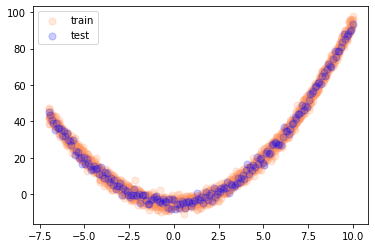

In [6]:
def generate_data(num_samples):

    # training data
    x = np.linspace(-7, 10, num_samples)[:, np.newaxis]
    noise = np.random.normal(0, 2, x.shape)
    y = np.square(x) - 5 + noise

    # test data
    test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
    noise = np.random.normal(0, 2, test_x.shape)
    test_y = np.square(test_x) - 5 + noise

    # to tensor
    train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
    test_x = torch.from_numpy(test_x).float()
    test_y = torch.from_numpy(test_y).float()

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = generate_data(2000)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

# show data
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.scatter(test_x.numpy(), test_y.numpy(), c='b', s=50, alpha=0.2, label='test')
plt.legend(loc='upper left')
plt.show()

In [7]:
class Net(nn.Module):
    
    def __init__(self, n_hidden, act_func, batch_normalization=False):
        super(Net, self).__init__()
        self.n_hidden = n_hidden
        self.act_func = act_func
        self.do_bn = batch_normalization
        self.fcs = []       # 利用list管理网络层，forward时，方便for循环调用每个网络层
        self.bns = []
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)   # for input data  ; momentum 是指数滑动平均的 decay?

        for i in range(n_hidden):               # build hidden layers and BN layers
            input_size = 1 if i == 0 else 10    # 写死了，第一层一个神经元，后面都是十个神经元
            fc = nn.Linear(input_size, 10)      # 设置网络层
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module 设置成类属性才可以进行更新

            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)

            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)

        self.predict = nn.Linear(10, 1)         # output layer
        self._set_init(self.predict)            # parameters initialization

    def _set_init(self, layer):
        nn.init.normal_(layer.weight, mean=0., std=.1)
        nn.init.constant_(layer.bias, -0.2)     # B_INIT = -0.2  # use a bad bias constant initializer

    def forward(self, x):

        pre_activation = [x]       # 收集数据，用以绘图
        if self.do_bn:
            x = self.bn_input(x)     # input batch normalization

        layer_input = [x]          # 收集数据，用以绘图

        for i in range(self.n_hidden):      # 设置断点，观察id(self.fc0), id(self.fcs[0])
            x = self.fcs[i](x)
            pre_activation.append(x)

            if self.do_bn:
                x = self.bns[i](x)   # batch normalization

            x = self.act_func(x)

            layer_input.append(x)
        out = self.predict(x)
        return out, layer_input, pre_activation
    

model = Net(n_hidden=3, act_func=torch.sigmoid, batch_normalization=True)
# model = Net(n_hidden=6, act_func=nn.Sigmoid, batch_normalization=False)
print(model)


Net(
  (bn_input): BatchNorm1d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (bn0): BatchNorm1d(10, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


In [8]:
fake_data = torch.normal(0, 1, size=(16, 1)) # 16是batch_size
print(fake_data.shape)
fake_data

torch.Size([16, 1])


tensor([[-0.5943],
        [-0.1485],
        [-0.2529],
        [-1.3820],
        [ 0.9392],
        [ 0.3562],
        [-0.6562],
        [ 0.6750],
        [-0.6830],
        [-0.8332],
        [-0.3416],
        [ 0.7182],
        [ 0.8067],
        [-0.7783],
        [ 0.0177],
        [ 1.1870]])

In [9]:
pred, layer_inputs, pre_activation = model(fake_data)
print(len(layer_inputs), len(pre_activation))

print(layer_inputs[0].shape)
print(layer_inputs[1].shape) # 10个神经元是个特征，16是batch_size
print(layer_inputs[2].shape)
print(layer_inputs[3].shape)

4 4
torch.Size([16, 1])
torch.Size([16, 10])
torch.Size([16, 10])
torch.Size([16, 10])


In [10]:
def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):

    for i, (ax_pa, ax_pa_bn, ax, ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0:
            p_range = (-7, 10)
            the_range = (-7, 10)
        else:
            p_range = (-4, 4)
            the_range = (-1, 1)
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].data.numpy().ravel(), bins=10, range=p_range, color='#FF9359', alpha=0.5)
        ax_pa_bn.hist(pre_ac_bn[i].data.numpy().ravel(), bins=10, range=p_range, color='#74BCFF', alpha=0.5)
        ax.hist(l_in[i].data.numpy().ravel(), bins=10, range=the_range, color='#FF9359')
        ax_bn.hist(l_in_bn[i].data.numpy().ravel(), bins=10, range=the_range, color='#74BCFF')
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]:
            a.set_yticks(())
            a.set_xticks(())

        ax_pa_bn.set_xticks(p_range)
        ax_bn.set_xticks(the_range)

        axs[0, 0].set_ylabel('PreAct')
        axs[1, 0].set_ylabel('BN PreAct')
        axs[2, 0].set_ylabel('Act')
        axs[3, 0].set_ylabel('BN Act')
        
    plt.suptitle("Activation:{} epoch:{}/{}".format(act_name, epoch, EPOCH))
    plt.pause(0.05)
    

In [11]:
# act_name = "ReLU"
# act_name = "Tanh"
act_name = "Sigmoid"
activations = {"ReLU": torch.relu, "Tanh": torch.tanh, "Sigmoid": torch.sigmoid}
ACTIVATION = activations[act_name]
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
N_SAMPLES = 2000
BATCH_SIZE = 64
B_INIT = -0.2  # use a bad bias constant initializer


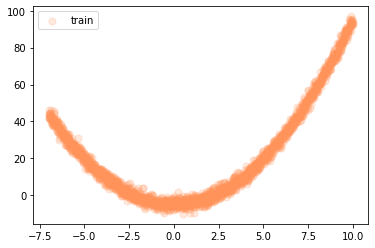

In [12]:
%matplotlib inline
# 1. 生成虚假数据
train_x, train_y, test_x, test_y = generate_data(N_SAMPLES)
train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# show data
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')

In [13]:
%matplotlib auto
# 2. 创建网络/loss/优化器
nets = [Net(N_HIDDEN, ACTIVATION, batch_normalization=False), Net(N_HIDDEN, ACTIVATION, batch_normalization=True)] #网络使用BN和不使用BN对比
loss_func = torch.nn.MSELoss()
opts = [torch.optim.Adam(net.parameters(), lr=LR) for net in nets]

# 3. 训练，绘图
f, axs = plt.subplots(4, N_HIDDEN + 1, figsize=(10, 5))
plt.ion()  # something about plotting
#plt.show()

losses = [[], []]  # recode loss for two networks
for epoch in range(EPOCH):
    print('Epoch: {}/{}'.format(epoch, EPOCH))

    # 记录数据
    layer_inputs, pre_acts = [], []
    for net, l in zip(nets, losses):
        net.eval()              # set eval mode to fix moving_mean and moving_var
        pred, layer_input, pre_act = net(test_x)
        l.append(loss_func(pred, test_y).data.item())
        layer_inputs.append(layer_input)
        pre_acts.append(pre_act)
        net.train()             # free moving_mean and moving_var
    plot_histogram(*layer_inputs, *pre_acts)     # plot histogram
    plt.show()
    # 训练更新模型
    for step, (b_x, b_y) in enumerate(train_loader):
        for net, opt in zip(nets, opts):     # train for each network
            pred, _, _ = net(b_x)
            loss = loss_func(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # it will also learns the parameters in Batch Normalization
plt.ioff()   

Using matplotlib backend: Qt5Agg
Epoch: 0/12
Epoch: 1/12
Epoch: 2/12
Epoch: 3/12
Epoch: 4/12
Epoch: 5/12
Epoch: 6/12
Epoch: 7/12
Epoch: 8/12
Epoch: 9/12
Epoch: 10/12
Epoch: 11/12


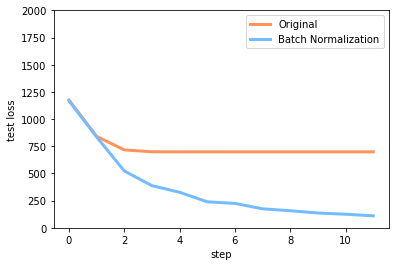

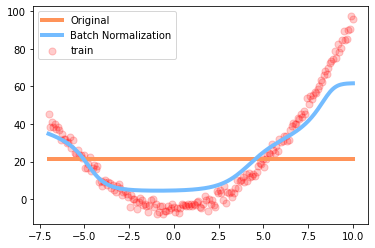

In [14]:
# plot training loss
%matplotlib inline
plt.figure(2)
plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
plt.xlabel('step')
plt.ylabel('test loss')
plt.ylim((0, 2000))
plt.legend(loc='best')

# evaluation
# set net to eval mode to freeze the parameters in batch normalization layers
[net.eval() for net in nets]    # set eval mode to fix moving_mean and moving_var
preds = [net(test_x)[0] for net in nets]
plt.figure(3)
plt.plot(test_x.data.numpy(), preds[0].data.numpy(), c='#FF9359', lw=4, label='Original') #original出现的是一个平直直线，意味着网络崩掉了
plt.plot(test_x.data.numpy(), preds[1].data.numpy(), c='#74BCFF', lw=4, label='Batch Normalization')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='train')
plt.legend(loc='best')
plt.show()

## Pycharm中实现动态图显示

### Mac
step1: Preference  
step2: Tools   
step3: Python Scientific   
step4: 不要勾选Show plots in tool window   
<img src="./imgs/pycharm.png"  width="800" height="500" align="bottom"/> 
